In [2]:
import numpy as np 
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

В качестве примера рассмотрим дневную доходность акций компании __Exxon Mobile__ за 51 месяц

In [3]:
start_date = "2015-01-01"
end_date = "2019-03-31"

Для загрузки данных будет использован модуль `pandas_datareader`, который позволяет импортировать данные из различных источников.

In [4]:
df = pdr.get_data_yahoo("XOM", start=start_date, end=end_date)

In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,93.050003,91.809998,92.250000,92.830002,10220400.0,75.439079
2015-01-05,92.400002,89.500000,92.099998,90.290001,18502400.0,73.374931
2015-01-06,91.410004,89.019997,90.239998,89.809998,16670700.0,72.984848
2015-01-07,91.480003,90.000000,90.650002,90.720001,13590700.0,73.724373
2015-01-08,92.269997,91.000000,91.250000,92.230003,15487500.0,74.951500


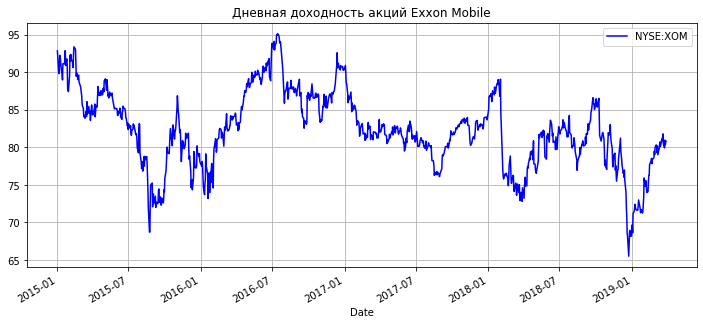

In [6]:
plt.figure(figsize=(12,5))
plt.title('Дневная доходность акций Exxon Mobile')

df.Close.plot(color='blue', grid=True, label='NYSE:XOM')
plt.legend()

### Стационарность ряда дневных доходностей 

Проверим временной ряд дневных дохоностей акции на случайное блуждание тестом Дики — Фуллера (ADF-тест, augmented Dickey — Fuller test). Этот тест является одним из тестов на единичные корни (Unit root test), которые показывают, насколько сильно временной ряд определяется трендом. Нулевая гипотеза теста состоит в том, что временной ряд может быть представлен единичным корнем, который не является стационарным, а альтернативная, таким образом, в том, что временной ряд стационарен.

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
adfuller_p = adfuller(df["Close"])[1]

In [9]:
f"p-value of ADF-test {adfuller_p:.3}"

'p-value of ADF-test 0.00804'

Как всегда, если `p-value < 0.05` мы отвергаем нулевую гипотезу.

### Автокорелляция

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

In [11]:
# для расчёта корреляции необходимо удалить пропущенные значения
df["Close"].dropna().autocorr()

0.9813634563032385

Применяя корреляция к значениями временного ряда вы будете стабильно получать её высокое значение. Это происходит потому что исходные значения временных рядов как правило нестационарны. Решением может быть использование для корреляции не исходные данные о ценах, а процентное изменение этих цен по сравнению с предыдущим шагом.

#### Первые 15 коэффициентов автокорреляции

In [12]:
acf(df["Close"].dropna(), unbiased=True, nlags=15, fft=False)

array([1.        , 0.980265  , 0.96115813, 0.94311594, 0.9254866 ,
       0.9096086 , 0.89435082, 0.8796382 , 0.86424773, 0.84904485,
       0.83301152, 0.81644762, 0.80088731, 0.78553931, 0.77004794,
       0.75551856])

#### График автокорреляции

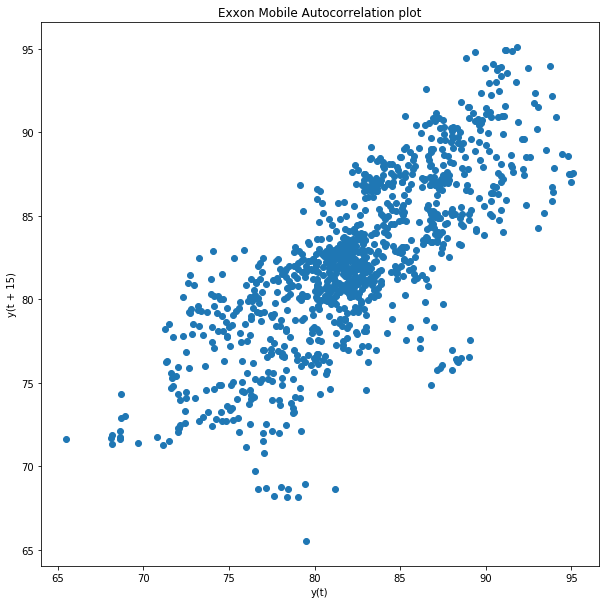

In [14]:
plt.figure(figsize=(10, 10))
lag_plot(df['Close'], lag=15)
plt.title('Exxon Mobile Autocorrelation plot');

#### График автокорреляционной функции 

Однако, является ли эта корреляция статистически значимой? Сила корреляции и её значимость — это совсем не одно и то же. Сила корреляции показывает степень линейной связи, а её значимость говорит о том, что наблюдаемой значение отличается от 0 с определённый вероятностью (обычно более 95%). Простой способ посчитать границы доверительных интервалов — вычислить значение выражения $±1.96 / \sqrt{N}±1.96$, где N — количество наблюдений. Такая оценка работает только если автокорреляции при любых лагах равны 0.

Итак, мы нашли автокорреляцию первого порядка. Её может и не быть, но это лишь значит, что может присутствовать автокорреляция высших порядков. Под порядком в данном случае понимается тот самый лаг между значениями временного ряда. Для того, чтобы выявить периодичность во временных рядах, используется функция автокорреляции — ACF, которая показывает значание автокорреляции для разных лагов.

График автокорреляций выборки в зависиости от сдвига называется коррелограммой, она проявляет неочевидные периодические составляющие сигнала. Построить коррелограмму можно при помощи модуля `plot_acf` библиотеки `statsmodels`. На графике также будет отобраён доверительный интервал, соответствующий уровню значимости $\alpha$

In [15]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 5)

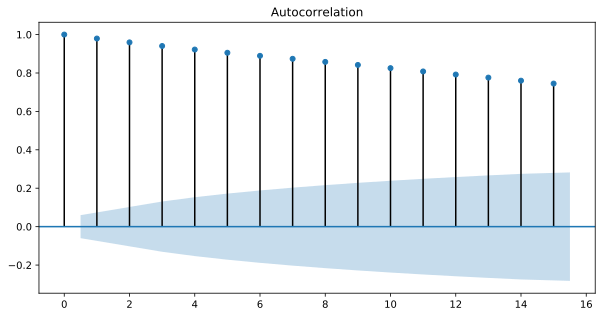

In [16]:
plot_acf(df["Close"].dropna(), lags=15);

Помимо ACF есть ещё PACF (частичная автокорреляционная фукнция), которая также показывает, значимо ли улучшение качества модели при увеличении её порядка. Для порядков, при которых значения PACF выходят за рамки доверительного интервала, можно говорить, о значительном приросте качества. Отличине в том, что в PACF рассчитывается только лишь корреляция между двумя переменных без влияния всех остальных.

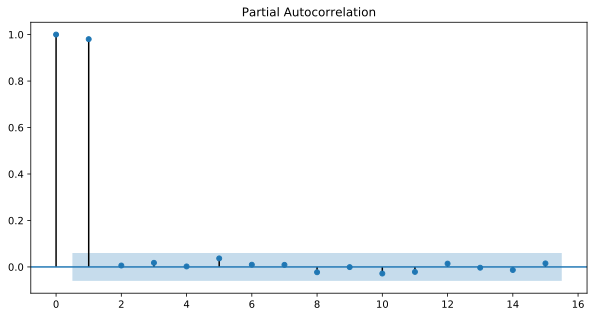

In [17]:
plot_pacf(df["Close"].dropna(), lags=15);

### Моделирование временных рядов регрессионными уравнениями

Разные регрессионным модели — это основной способ моделирования временных рядов. Самый популярная модель называется ARIMA — интегрированная модель авторегрессии — скользящего среднего (autoregressive integrated moving average). Есть множество других, более сложных и специализированных моделей, рифмующихся с ней: SARIMA, ARFIMA, VARMA и другие. Мы коснёмся и их, но вначале разберём три более простые модели — AR, MA и ARMA, которая является обобщением двух предыдущих.

#### Модель авторегрессии (AR, autoregression)

Модели авторегрессии и скользящего среднего строятся исходя из условия стационарности. Стационарный процесс в сильном смысле — это процесс, в котором распределение случайной величины не изменяется со временем, а в слабом — это процесс с постоянным математическим ожиданием и дисперсией, в котором ковариация между значениями ряда зависит только от величины лага.

Условие стационарности для моделей ARMA связано с идеей, лежащей в основе модели линейного фильтра, на которой базируется ARMA: временнóй ряд рассматривается как генерируемый под влиянием ряда независимых случайных ошибок (шумов, шоков), имеющих некое фиксированное распределение (обычно нормальное). Согласно этой идее случайные шоки проходят через фильтр (в роли которого выступает модель ARMA), на выходе которого получаются значения ряда $y_t$. Для моделирования технических процессов такая модель работает, но социально-экономические процессы, конечно же, значительно более разнообразны, а поэтому и нестационарность в них встречается значительно чаще.

In [47]:
#df.index = pd.DatetimeIndex(df.index).to_period('W')

In [18]:
df = df.groupby(pd.Grouper(freq='W')).aggregate("mean") # упаковываем дневные доходности в недельные

In [19]:
model = ARMA(df.Close.dropna(), order=(1, 0));
model = model.fit();
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  222
Model:                     ARMA(1, 0)   Log Likelihood                -428.767
Method:                       css-mle   S.D. of innovations              1.661
Date:                Thu, 30 Apr 2020   AIC                            863.534
Time:                        22:33:38   BIC                            873.743
Sample:                    01-04-2015   HQIC                           867.656
                         - 03-31-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          82.9931      2.051     40.470      0.000      78.974      87.012
ar.L1.Close     0.9494      0.021     44.761      0.000       0.908       0.991
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           +0.0000j            1.0533            0.0000
-----------------------------------------------------------------------------
"""

#### Прогнозирование по ARMA доходности за 5 недель

In [20]:
df.loc['2019-3'].Close # реальная доходность акций

Date
2019-03-03    79.132001
2019-03-10    79.790001
2019-03-17    80.216000
2019-03-24    81.108002
2019-03-31    80.551999
Freq: W-SUN, Name: Close, dtype: float64

In [21]:
predicted = model.predict(start="2019-03", end="2019-03") # прогноз модели

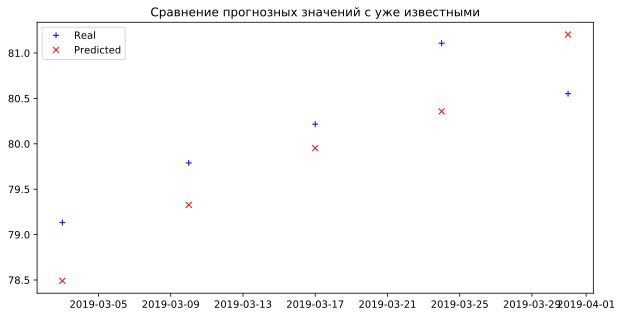

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(df.loc['2019-3'].Close, 'b+', label='Real')
plt.plot(predicted, 'rx', label='Predicted')
plt.legend()
plt.title('Сравнение прогнозных значений с уже известными');

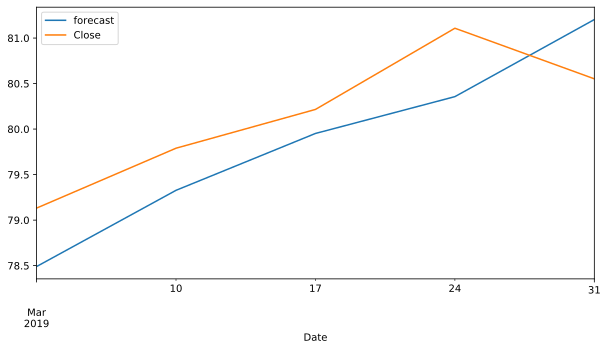

In [23]:
model.plot_predict(start="2019-03", end="2019-03");

In [25]:
pred = model.predict(start="2019-04", end="2019-05-05")

In [26]:
pred

2019-04-07    80.675528
2019-04-14    80.792806
2019-04-21    80.904150
2019-04-28    81.009859
2019-05-05    81.110218
Freq: W-SUN, dtype: float64

<Figure size 720x360 with 0 Axes>

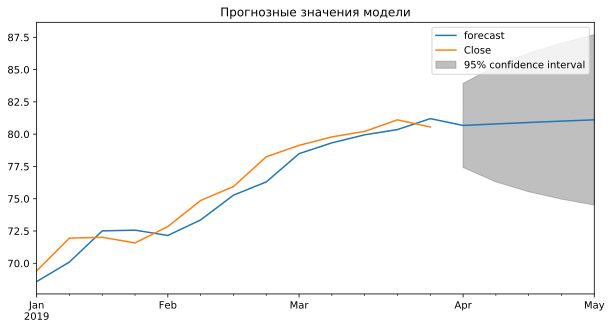

In [27]:
plt.figure(figsize=(10, 5));
model.plot_predict(start="2019-01", end="2019-05-05");
plt.title('Прогнозные значения модели');